In [167]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

from imblearn.under_sampling import TomekLinks

from xgboost import XGBClassifier
from catboost import CatBoostClassifier



In [102]:
train_1 = pd.read_csv("train.csv")
train_1['original'] = 0
train_2 = pd.read_csv("train_original_dataset.csv")
train_2['original'] = 1
test = pd.read_csv("test.csv")
train_1.info()
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [103]:
train_1.drop(columns = 'id', inplace = True)
train = pd.concat([train_1, train_2])
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198240 entries, 0 to 38983
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  198240 non-null  int64  
 1   height(cm)           198240 non-null  int64  
 2   weight(kg)           198240 non-null  int64  
 3   waist(cm)            198240 non-null  float64
 4   eyesight(left)       198240 non-null  float64
 5   eyesight(right)      198240 non-null  float64
 6   hearing(left)        198240 non-null  int64  
 7   hearing(right)       198240 non-null  int64  
 8   systolic             198240 non-null  int64  
 9   relaxation           198240 non-null  int64  
 10  fasting blood sugar  198240 non-null  int64  
 11  Cholesterol          198240 non-null  int64  
 12  triglyceride         198240 non-null  int64  
 13  HDL                  198240 non-null  int64  
 14  LDL                  198240 non-null  int64  
 15  hemoglobin           19

In [104]:
target = train['smoking']
target.value_counts()
# Not quite equal. More non-smokers than smokers

smoking
0    114269
1     83971
Name: count, dtype: int64

In [105]:
train.isnull().sum()
# No missing data here.

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
original               0
dtype: int64

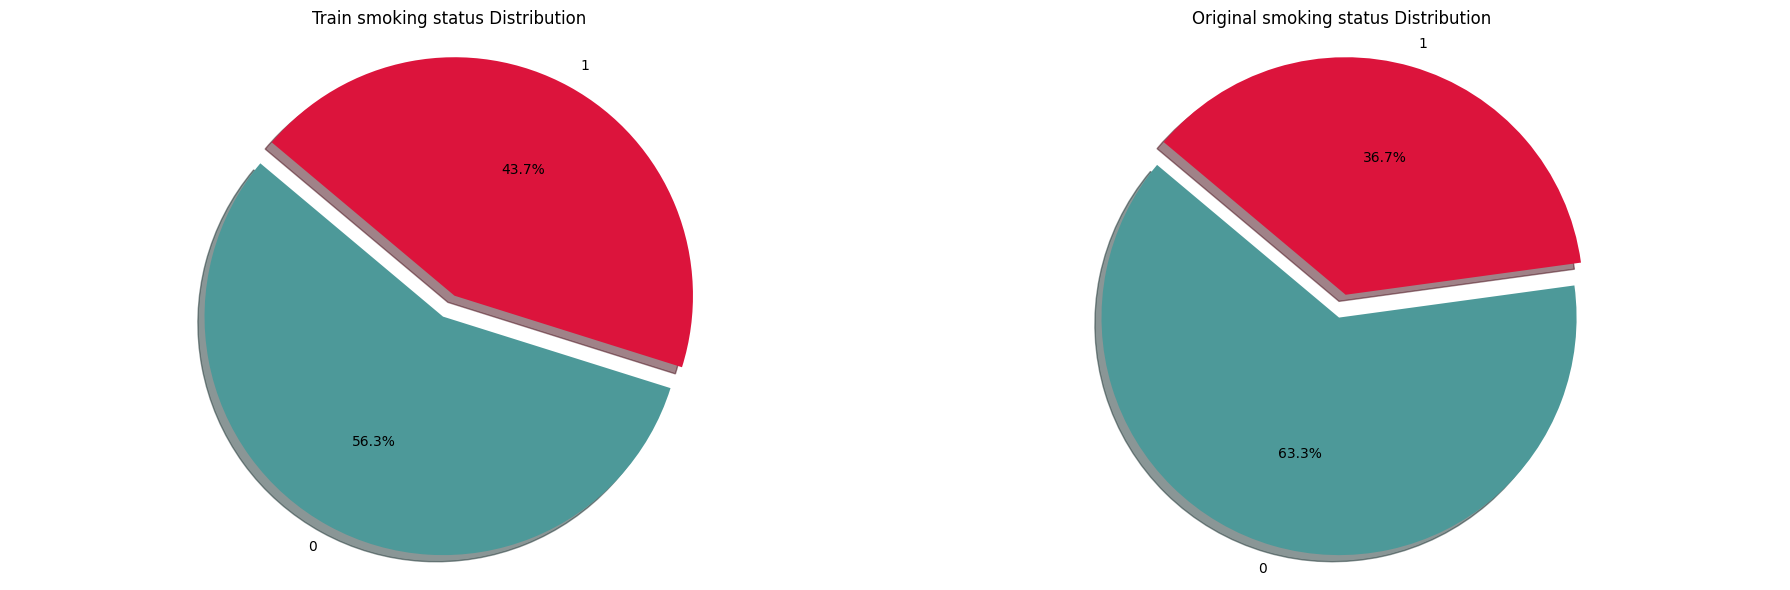

In [106]:
def plot_pie_chart(data, title, ax):
    data_counts = data['smoking'].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [ (0.3, 0.6, 0.6), 'crimson']  
    explode = (0.1, 0)  

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal') 
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Create three subplots in a row

plot_pie_chart(train_1, "Train smoking status Distribution", axes[0])
plot_pie_chart(train_2, "Original smoking status Distribution", axes[1])

plt.tight_layout()
plt.show()

# There are more smokers in the original dataset compared to the simulated data, which is more balanced.

In [107]:
train.drop(columns = ['original'], inplace = True)

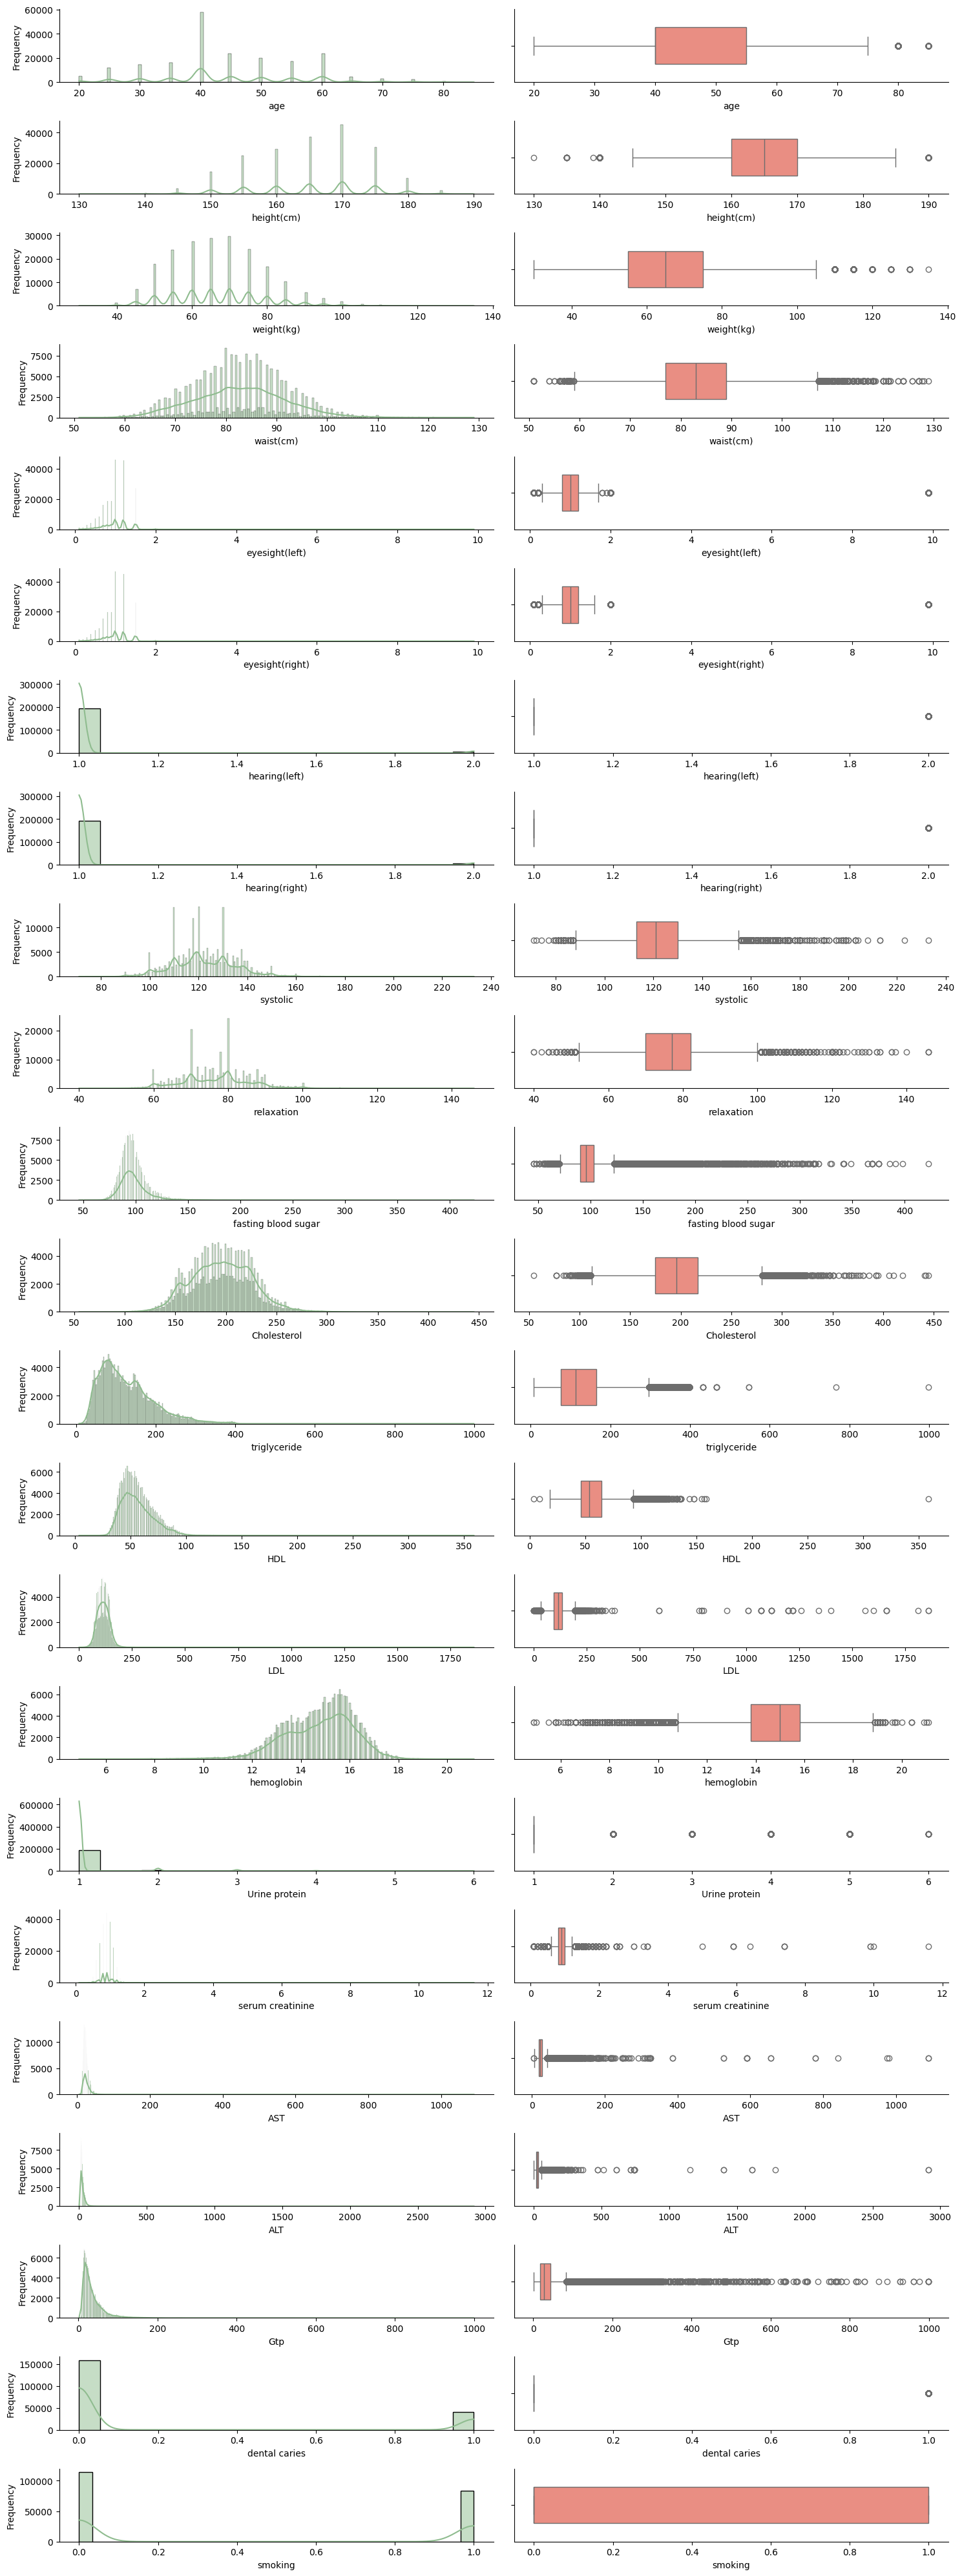

In [108]:
# Time for a quick eda. First, lets look at the distribution of each variable.
features = train.copy()

fig, axes = plt.subplots(23, 2, figsize = (15, 40))

# Full credit to m000sey for this block of code, even the colours. He just picked some very nice ones!

for i, column in enumerate(features.columns):
    # plot histograms
    ax_histo = axes[i, 0]
    ax_histo = sns.histplot(features[column], kde = True, ax = ax_histo, color = 'darkseagreen')
    ax_histo.set_xlabel(column)
    ax_histo.set_ylabel("Frequency")
    
    # remove top and right side of histogram
    ax_histo.spines['top'].set_visible(False)
    ax_histo.spines['right'].set_visible(False)
    
    # set grid to invisible
    ax_histo.grid(visible = False)
    
    # plot boxplots
    ax_box = axes[i, 1]
    sns.boxplot(data = features, x = column, width = 0.5, ax = ax_box, color = 'salmon')
    ax_box.set_xlabel(column)
    ax_box.set_ylabel("")

    # remove top and right side of bxplot
    ax_box.spines['top'].set_visible(False)
    ax_box.spines['right'].set_visible(False)
    
    # set grid to invisible
    ax_box.grid(visible = False)
    
plt.tight_layout()
plt.show()




I am probably gonna go with a randomforest at first, so the distribution isn't quite as important. But I may want to try a simple logistic regression later, in which case i'll transform most of these.

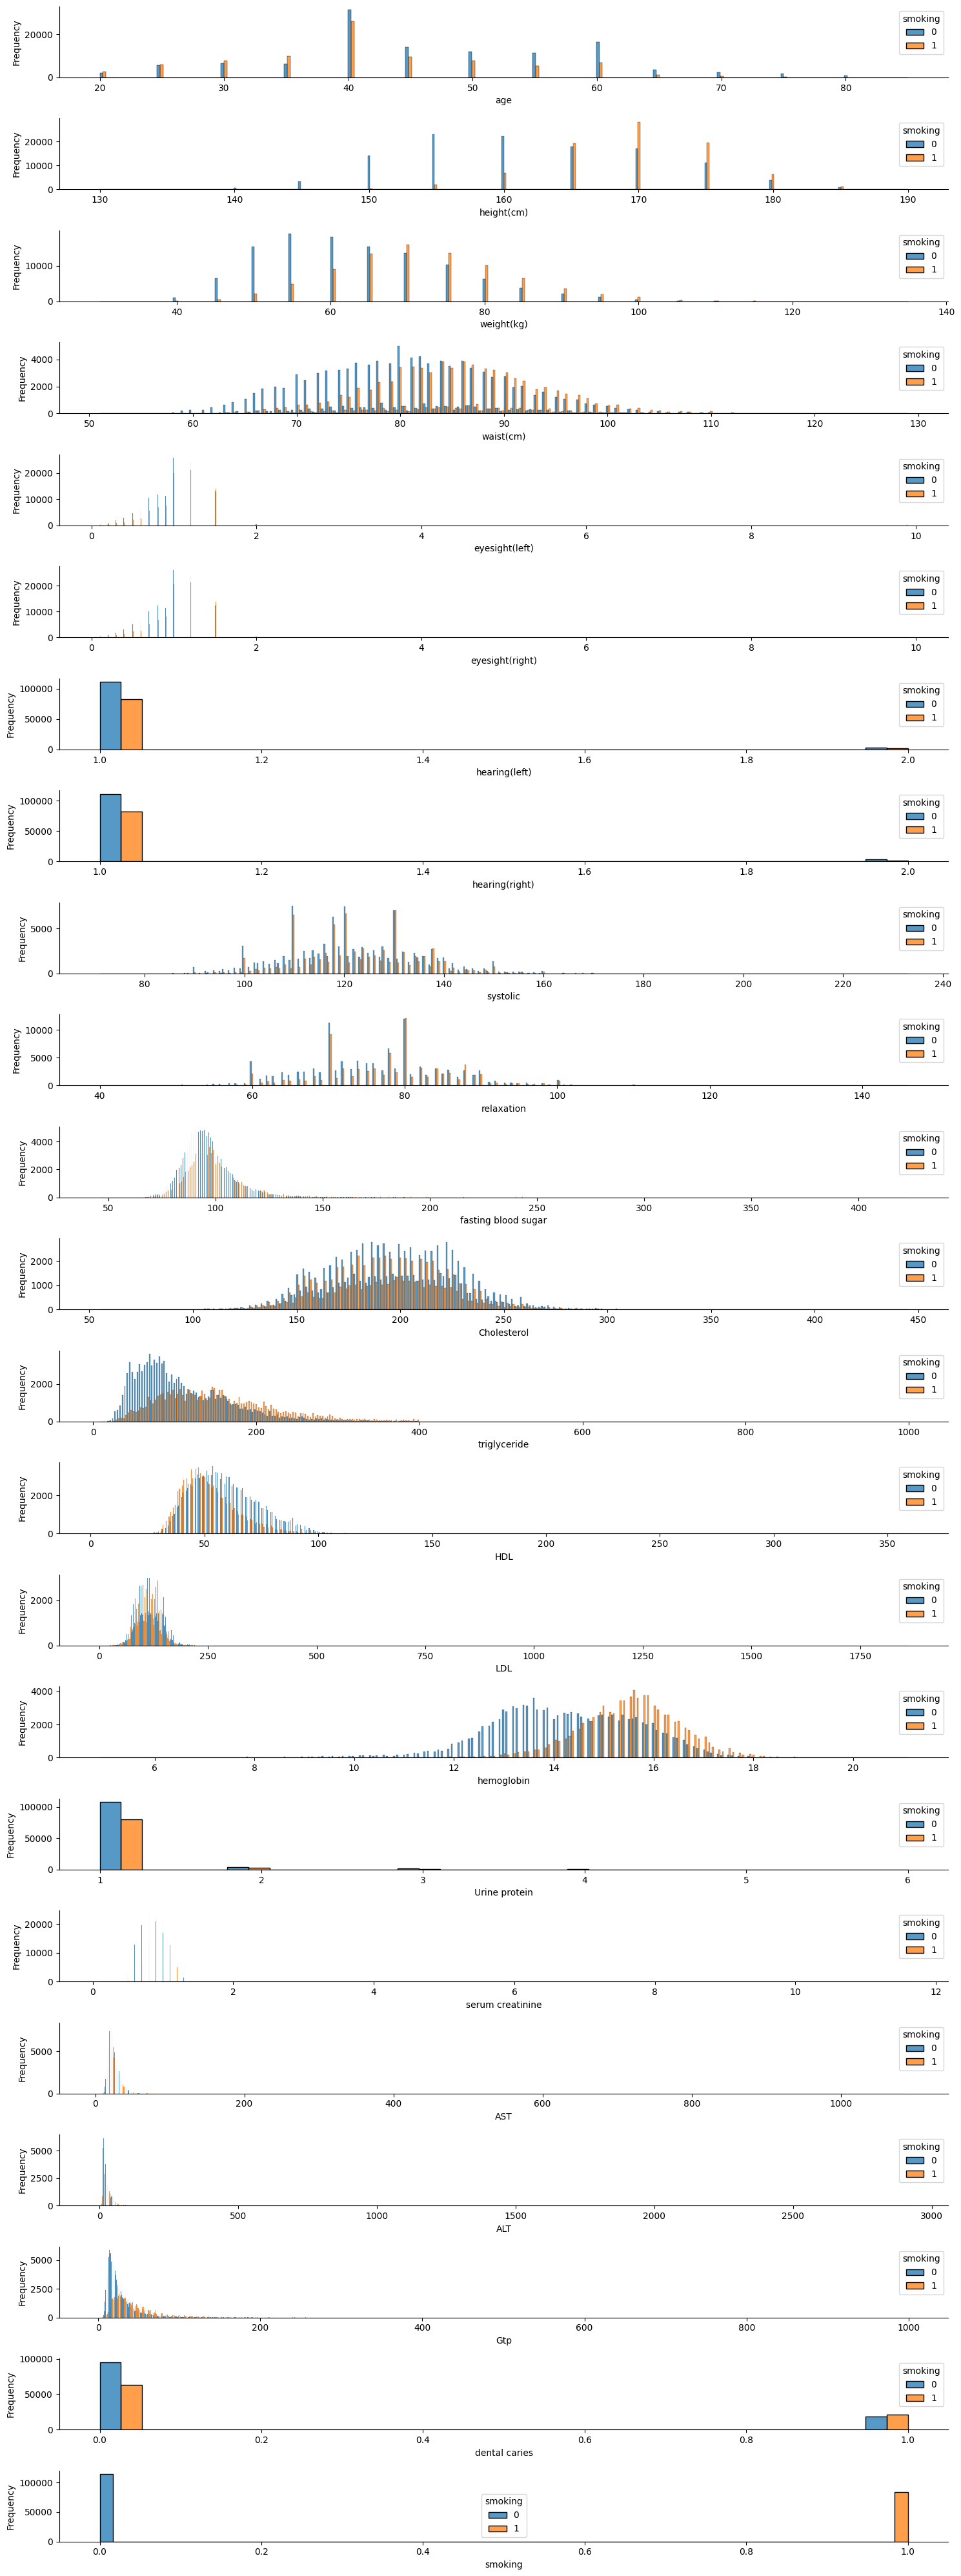

In [109]:
fig, axes = plt.subplots(23, 1, figsize = (15, 40))

# Full credit to m000sey for this block of code, even the colours. He just picked some very nice ones!

for i, column in enumerate(features.columns):
    # plot histograms
    ax_histo = axes[i]
    ax_histo = sns.histplot(x = features[column], hue = features['smoking'], multiple = 'dodge', shrink = 1, ax = ax_histo)
    ax_histo.set_xlabel(column)
    ax_histo.set_ylabel("Frequency")
    
    # remove top and right side of histogram
    ax_histo.spines['top'].set_visible(False)
    ax_histo.spines['right'].set_visible(False)
    
    # set grid to invisible
    ax_histo.grid(visible = False)
    
plt.tight_layout()
plt.show()

There is a little bit going on here. It's a bit hard to read (and i'll try and fix this later), but what seems obvious:
* Taller and heavier individuals seem more likely to smoke. Theres probably a common underlying factor there. Maybe gender.
* Theres something weird going on with fasting blood sugar. I need to have a proper look at this.
* Triglyceride (count?) is generally lower for non-smokers.
* HDL is generally higher for non-smokers
* Hemoglobin is lower for non-smokers
* serum creatinine is lower for non-smokers
* ALT is lower for non-smokers
* GTP is lower for non-smokers

Need to look at fasting blood sugar and LDL in more detail.

Of course one thing to note is that we are not taking into account the fact that there are less smokers. This will be driving some of the differences.
It would be wise to plot this instead.

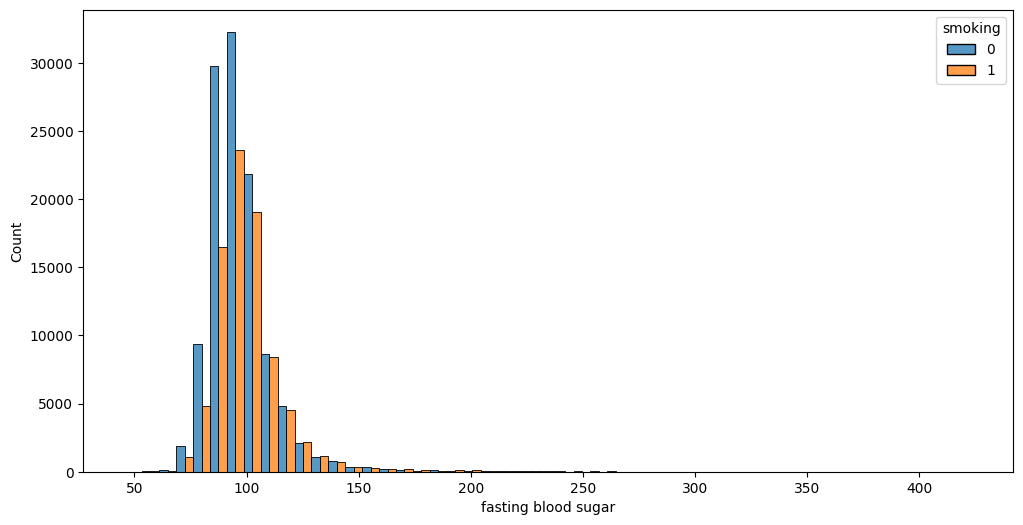

In [110]:
# Time to see whats going on with fasting blood sugar

plt.figure(figsize = (12, 6))
sns.histplot(x = train['fasting blood sugar'], hue = train['smoking'], bins = 50, multiple = 'dodge')
plt.show()

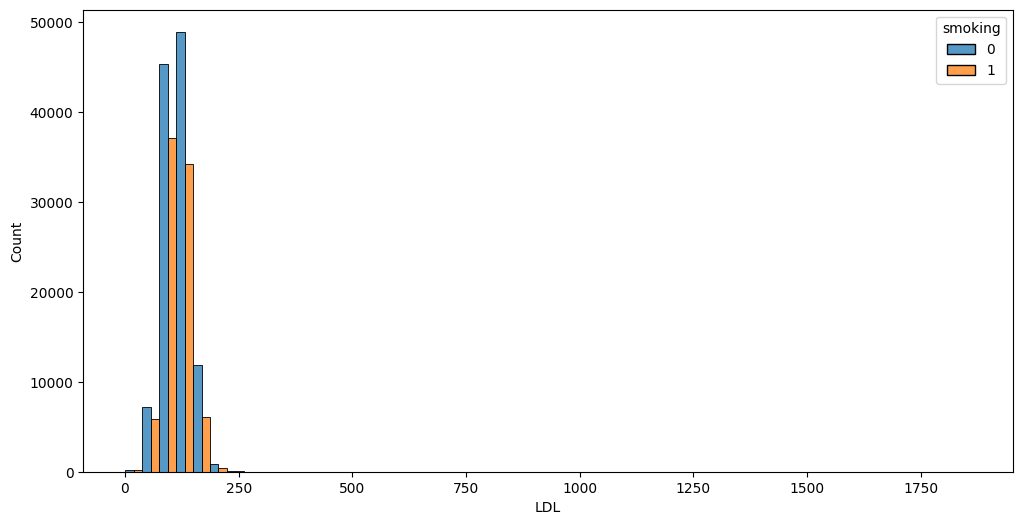

In [111]:
# Time to see whats going on with LDL

plt.figure(figsize = (12, 6))
sns.histplot(x = train['LDL'], hue = train['smoking'], bins = 50, multiple = 'dodge')
plt.show()

Fasting blood sugar is still a bit ambiguous, but it seems to be lower for non-smokers, this makes sense.
LDL is definitely lower for non-smokers.

In [112]:
correlations = train.corr()
smoking_correlations = correlations['smoking']
print(smoking_correlations.sort_values())

HDL                   -0.254475
age                   -0.197586
LDL                   -0.063120
Cholesterol           -0.046617
hearing(left)         -0.035186
hearing(right)        -0.033604
Urine protein         -0.020131
AST                    0.055705
systolic               0.062593
eyesight(left)         0.089973
fasting blood sugar    0.094883
eyesight(right)        0.098198
dental caries          0.105695
relaxation             0.110132
ALT                    0.137933
waist(cm)              0.256513
serum creatinine       0.258388
Gtp                    0.277741
triglyceride           0.314849
weight(kg)             0.342749
height(cm)             0.437073
hemoglobin             0.441413
smoking                1.000000
Name: smoking, dtype: float64


# Feature Engineering

In [113]:
# credit to [@paddykb](https://www.kaggle.com/code/paddykb/pg-s3e24-brute-force-and-ignorance) 
# & [@arunklenin] (https://www.kaggle.com/code/arunklenin/ps3e24-eda-feature-engineering-ensemble)

def create_extra_features(df):
    best = np.where(df['hearing(left)'] < df['hearing(right)'], 
                    df['hearing(left)'],  df['hearing(right)'])
    worst = np.where(df['hearing(left)'] < df['hearing(right)'], 
                     df['hearing(right)'],  df['hearing(left)'])
    df['hearing(left)'] = best - 1
    df['hearing(right)'] = worst - 1
    
    df['eyesight(left)'] = np.where(df['eyesight(left)'] > 9, 0, df['eyesight(left)'])
    df['eyesight(right)'] = np.where(df['eyesight(right)'] > 9, 0, df['eyesight(right)'])
    best = np.where(df['eyesight(left)'] < df['eyesight(right)'], 
                    df['eyesight(left)'],  df['eyesight(right)'])
    worst = np.where(df['eyesight(left)'] < df['eyesight(right)'], 
                     df['eyesight(right)'],  df['eyesight(left)'])
    df['eyesight(left)'] = best
    df['eyesight(right)'] = worst
    ##
    df['Gtp'] = np.clip(df['Gtp'], 0, 300)
    df['HDL'] = np.clip(df['HDL'], 0, 110)
    df['LDL'] = np.clip(df['LDL'], 0, 200)
    df['ALT'] = np.clip(df['ALT'], 0, 150)
    df['AST'] = np.clip(df['AST'], 0, 100)
    df['serum creatinine'] = np.clip(df['serum creatinine'], 0, 3)  
    
    df['BMI'] = df['weight(kg)'] / ((df['height(cm)']/100) ** 2)
    df['HW_Ratio'] = df['height(cm)'] / df['waist(cm)']
    df['HA_Ratio'] = df['height(cm)'] / df['age']
    
    return df
train=create_extra_features(train)
test=create_extra_features(test)

In [114]:
tomek = TomekLinks(sampling_strategy = 'auto')

train, target = tomek.fit_resample(train, target)


In [151]:
object_variables = ['hearing(left)', 'hearing(right)', 'dental caries', 'Urine protein']
train[object_variables] = train[object_variables].astype('object')
test[object_variables] = test[object_variables].astype('object')

num_variables_df = train.drop(object_variables, axis = 1)
num_variables = num_variables_df.columns

In [116]:
num_variables_test = num_variables.drop(['smoking'])


In [117]:
test.drop(columns = ['id'], inplace = True)

In [152]:
scaler = RobustScaler()

scaled_train = pd.DataFrame(scaler.fit_transform(train[num_variables]), columns = num_variables)
scaled_test = pd.DataFrame(scaler.fit_transform(test[num_variables_test]), columns = num_variables_test)

In [153]:
ohe_train = pd.get_dummies(train[object_variables])
ohe_test  = pd.get_dummies(test[object_variables])

In [154]:
for i in ohe_train.columns : 
    ohe_train[i] = ohe_train[i].apply(lambda x :0.9 if x ==1 else 0.1)
for i in ohe_test.columns : 
    ohe_test[i] = ohe_test[i].apply(lambda x :0.9 if x ==1 else 0.1)

In [155]:
ohe_train = ohe_train.reset_index(drop = True)
ohe_test = ohe_test.reset_index(drop = True)
scaled_train = scaled_train.reset_index(drop = True)
scaled_test = scaled_test.reset_index(drop = True)

In [156]:
new_train = pd.concat([ohe_train, scaled_train], axis = 1)
new_test = pd.concat([ohe_test, scaled_test], axis = 1)
new_train.head(10)

,hearing(left)_0,hearing(left)_1,hearing(right)_0,hearing(right)_1,dental caries_0,dental caries_1,Urine protein_1,Urine protein_2,Urine protein_3,Urine protein_4,...,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,smoking,BMI,HW_Ratio,HA_Ratio
0,0.9,0.1,0.9,0.1,0.9,0.1,0.9,0.1,0.1,0.1,...,-0.975,0.761905,0.5,-0.111111,0.1875,0.000000,1.0,-0.534513,0.138272,-0.583333
1,0.1,0.9,0.1,0.9,0.1,0.9,0.9,0.1,0.1,0.1,...,0.300,0.619048,1.0,0.444444,0.0625,0.384615,0.0,-0.084806,-0.545318,-1.011905
2,0.9,0.1,0.9,0.1,0.9,0.1,0.9,0.1,0.1,0.1,...,-0.525,1.190476,-0.5,0.444444,0.5625,1.000000,1.0,0.423642,0.368724,3.083333
3,0.9,0.1,0.9,0.1,0.9,0.1,0.9,0.1,0.1,0.1,...,-0.525,0.238095,-0.5,-0.444444,-0.5625,-0.384615,1.0,-0.534513,0.185507,1.083333
4,0.9,0.1,0.9,0.1,0.1,0.9,0.9,0.1,0.1,0.1,...,-0.375,0.476190,-1.0,0.111111,1.2500,3.538462,1.0,-1.270926,4.977778,-0.316667
5,0.9,0.1,0.9,0.1,0.9,0.1,0.9,0.1,0.1,0.1,...,0.200,-0.904762,-1.0,-0.666667,-0.6250,-0.423077,0.0,-0.670215,1.190338,-0.212963
6,0.9,0.1,0.9,0.1,0.9,0.1,0.9,0.1,0.1,0.1,...,2.100,-0.190476,-1.0,-0.777778,-0.4375,-0.423077,0.0,0.184269,-0.618540,-0.704545
7,0.9,0.1,0.9,0.1,0.9,0.1,0.9,0.1,0.1,0.1,...,0.900,0.380952,0.0,0.111111,-0.0625,0.153846,1.0,0.364900,-0.545318,0.166667
8,0.9,0.1,0.9,0.1,0.9,0.1,0.9,0.1,0.1,0.1,...,0.200,-0.809524,-1.0,-0.111111,-0.3750,-0.500000,0.0,-0.834941,0.460274,0.000000
9,0.9,0.1,0.9,0.1,0.9,0.1,0.1,0.1,0.9,0.1,...,-0.325,-0.952381,-1.0,-0.666667,-0.6875,-0.730769,0.0,-0.834941,1.043137,0.000000


# Model Training

In [158]:
x_train = new_train.drop(columns = ["smoking"], axis = 1)
y_train = new_train['smoking']

In [80]:
rfc = RandomForestClassifier()

scores = cross_val_score(rfc, x_train, y_train.values.ravel(), scoring = 'roc_auc', cv = 3)
print(scores.mean())

0.8742424281911788


In [168]:
xclf = XGBClassifier()

scores = cross_val_score(rfc, x_train, y_train.values.ravel(), scoring = 'roc_auc', cv = 3)
print(scores.mean())

0.8744114572495022


In [169]:
catclf = CatBoostClassifier()

scores = cross_val_score(rfc, x_train, y_train.values.ravel(), scoring = 'roc_auc', cv = 3)
print(scores.mean())

0.8739814214067999


In [170]:
rfc.fit(x_train, y_train.values.ravel())
predictions_rfc = rfc.predict(new_test)

xclf.fit(x_train, y_train.values.ravel())
predictions_xclf = xclf.predict(new_test)

catclf.fit(x_train, y_train.values.ravel())
predictions_catclf = catclf.predict(new_test)


c:\Users\tj317\kaggle_environment1\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\tj317\kaggle_environment1\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\tj317\kaggle_environment1\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\tj317\kaggle_environment1\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or i

Learning rate set to 0.096206
0:	learn: 0.6433631	total: 202ms	remaining: 3m 22s
1:	learn: 0.6054296	total: 255ms	remaining: 2m 7s
2:	learn: 0.5758093	total: 305ms	remaining: 1m 41s
3:	learn: 0.5523314	total: 348ms	remaining: 1m 26s
4:	learn: 0.5345585	total: 402ms	remaining: 1m 20s
5:	learn: 0.5198651	total: 469ms	remaining: 1m 17s
6:	learn: 0.5090046	total: 535ms	remaining: 1m 15s
7:	learn: 0.5001804	total: 605ms	remaining: 1m 15s
8:	learn: 0.4923372	total: 685ms	remaining: 1m 15s
9:	learn: 0.4856320	total: 764ms	remaining: 1m 15s
10:	learn: 0.4805576	total: 852ms	remaining: 1m 16s
11:	learn: 0.4759097	total: 911ms	remaining: 1m 15s
12:	learn: 0.4724161	total: 982ms	remaining: 1m 14s
13:	learn: 0.4693010	total: 1.06s	remaining: 1m 14s
14:	learn: 0.4665863	total: 1.13s	remaining: 1m 14s
15:	learn: 0.4638489	total: 1.23s	remaining: 1m 15s
16:	learn: 0.4616784	total: 1.29s	remaining: 1m 14s
17:	learn: 0.4596114	total: 1.34s	remaining: 1m 13s
18:	learn: 0.4578496	total: 1.39s	remaining: 

In [178]:
print(predictions_catclf.shape)
print(predictions_xclf.shape)
print(predictions_rfc.shape)

predictions = pd.DataFrame(columns = ['randomforest', 'catboost', 'xgboost'])
predictions['randomforest'] = predictions_rfc
predictions['catboost'] = predictions_catclf
predictions['xgboost'] = predictions_xclf
#predictions = np.concatenate([predictions_catclf, predictions_rfc, predictions_xclf])

(106171,)
(106171,)
(106171,)


In [180]:
predictions['average'] = predictions.mean(axis = 1)

In [183]:
predictions['weighted_average'] = predictions_xclf * 0.6 + predictions_catclf * 0.3 + predictions_rfc * 0.1

In [186]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.drop(columns = 'smoking', inplace = True)
sample_submission['smoking'] = predictions['weighted_average']
sample_submission.to_csv('submission_3.csv', index = False)